In [70]:
import osmnx as ox
import geopandas as gp
import rasterio as ro
from matplotlib import pyplot
import seaborn as sea
import numpy as np
import math

In [2]:
G = ox.graph_from_place("Washington", which_result=2)

In [3]:
G_proj = ox.project_graph(G)
gdf_proj = ox.graph_to_gdfs(G_proj, edges=True)

In [4]:
gdf_proj_small = gdf_proj[1].drop(columns=['name','service','access','lanes','ref','maxspeed','tunnel','bridge','junction','width','area'])

In [5]:
gdf_proj_small

,u,v,key,osmid,highway,oneway,length,geometry
0,2039087104,2039087110,0,193399558,footway,False,12.533,"LINESTRING (325018.628 4307295.052, 325029.333..."
1,2039087104,2039087094,0,777488803,footway,False,6.807,"LINESTRING (325018.628 4307295.052, 325014.293..."
2,2039087104,6312468182,0,193399558,footway,False,16.527,"LINESTRING (325018.628 4307295.052, 325016.268..."
3,2039087105,2039087117,0,193399558,footway,False,11.744,"LINESTRING (325052.454 4307294.770, 325042.627..."
4,2039087105,2039087050,0,193399562,footway,False,7.305,"LINESTRING (325052.454 4307294.770, 325058.085..."
...,...,...,...,...,...,...,...,...
119517,2039087100,2039087102,0,193399558,footway,False,7.142,"LINESTRING (325034.118 4307204.091, 325041.047..."
119518,2039087100,2039087118,0,193399558,footway,False,7.188,"LINESTRING (325034.118 4307204.091, 325027.109..."
119519,2039087102,2039087099,0,193399548,footway,False,26.465,"LINESTRING (325041.047 4307205.881, 325041.467..."
119520,2039087102,2039087100,0,193399558,footway,False,7.142,"LINESTRING (325041.047 4307205.881, 325034.118..."


In [6]:
gdf_proj_small['highway'].value_counts()

service                       37411
residential                   30087
footway                       26714
tertiary                       7485
primary                        6097
                              ...  
[footway, cycleway, path]         1
[trunk_link, tertiary]            1
[primary, motorway_link]          1
[primary, footway]                1
[secondary, motorway_link]        1
Name: highway, Length: 71, dtype: int64

In [7]:
elevation_raster = ro.open("BARE_EARTH_2015/BareEarth2015.tif")

In [8]:
type(elevation_raster)

rasterio.io.DatasetReader

In [9]:
elevation_raster.crs.data

{'proj': 'lcc',
 'lat_0': 37.6666666666667,
 'lon_0': -77,
 'lat_1': 38.3,
 'lat_2': 39.45,
 'x_0': 400000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [10]:
elevation_data = elevation_raster.read(1)

In [11]:
elevation_data.shape

(39371, 31497)

In [12]:
elevation_data[10000,20000]

29.717

In [13]:
gdf_proj_small_crsed = gdf_proj_small.to_crs(elevation_raster.crs.data)

TODO: What is a row? Intersection to intersection? node to node?

In [14]:
gdf_proj_small_crsed['geometry'][0].coords[:]

[(398459.55829222145, 136585.62935716865),
 (398470.1167774988, 136592.4098775791)]

In [15]:
for (x,y) in gdf_proj_small_crsed['geometry'][4].coords[:]:
    i,j = elevation_raster.index(x,y)
    print(i,j)
    print(elevation_data[i,j])
    

19052 14917
12.706
19044 14926
12.569


In [16]:
def get_elevs(linestring):
    elevs = []
    for (x,y) in linestring.coords[:]:
        i,j = elevation_raster.index(x,y)
        elev = elevation_data[i,j]
        elevs.append(elev)
    return elevs

In [17]:
gdf_proj_small_crsed['elevs'] = gdf_proj_small_crsed['geometry'].map(get_elevs)

In [18]:
all_elevs = gdf_proj_small_crsed['elevs']

In [20]:
all_elevs.explode().describe()

count     4.345640e+05
unique    7.656700e+04
top      -3.402823e+38
freq      7.500000e+03
Name: elevs, dtype: float64

In [29]:
m = gdf_proj_small_crsed.elevs.map(lambda x : any([y < -30000 for y in x]))

In [32]:
off_the_map_check = gdf_proj_small_crsed[m]

In [33]:
off_the_map_check

,u,v,key,osmid,highway,oneway,length,geometry,elevs
25,5565448195,776362176,0,581729875,path,False,12.413,"LINESTRING (403800.466 138356.352, 403808.268 ...","[-3.4028235e+38, 30.57]"
26,5565448195,776362104,0,581729874,path,False,14.714,"LINESTRING (403800.466 138356.352, 403797.217 ...","[-3.4028235e+38, 30.991, 30.155]"
27,5565448195,5565448199,0,581729875,path,False,12.970,"LINESTRING (403800.466 138356.352, 403795.111 ...","[-3.4028235e+38, 33.931, 34.54]"
45,5565448199,5565448195,0,581729875,path,False,12.970,"LINESTRING (403794.884 138367.694, 403795.111 ...","[34.54, 33.931, -3.4028235e+38]"
110,1458176045,6346107644,0,6059746,tertiary,True,228.338,"LINESTRING (398697.858 135941.574, 398706.741 ...","[3.027, 2.946, 3.092, 3.108, -3.4028235e+38, -..."
...,...,...,...,...,...,...,...,...,...
117884,3010721844,2790994853,0,385380676,footway,False,4.115,"LINESTRING (398931.619 136076.558, 398931.689 ...","[-3.4028235e+38, -3.4028235e+38]"
117885,3010721844,3010721849,0,385380676,footway,False,28.292,"LINESTRING (398931.619 136076.558, 398931.164 ...","[-3.4028235e+38, -3.4028235e+38]"
117889,3010721849,3010721842,0,385380673,footway,False,33.299,"LINESTRING (398931.164 136048.317, 398897.816 ...","[-3.4028235e+38, -3.4028235e+38]"
117890,3010721849,3010721844,0,385380676,footway,False,28.292,"LINESTRING (398931.164 136048.317, 398931.619 ...","[-3.4028235e+38, -3.4028235e+38]"


In [51]:
gdf_clean = gdf_proj_small_crsed[m.map(lambda x : not(x))]

In [64]:
gdf_clean

,u,v,key,osmid,highway,oneway,length,geometry,elevs
0,2039087104,2039087110,0,193399558,footway,False,12.533,"LINESTRING (398459.558 136585.629, 398470.117 ...","[12.869, 12.774]"
1,2039087104,2039087094,0,777488803,footway,False,6.807,"LINESTRING (398459.558 136585.629, 398455.109 ...","[12.869, 12.869]"
2,2039087104,6312468182,0,193399558,footway,False,16.527,"LINESTRING (398459.558 136585.629, 398457.268 ...","[12.869, 13.33, 13.264, 13.032]"
3,2039087105,2039087117,0,193399558,footway,False,11.744,"LINESTRING (398493.381 136586.089, 398483.415 ...","[12.706, 12.781]"
4,2039087105,2039087050,0,193399562,footway,False,7.305,"LINESTRING (398493.381 136586.089, 398498.908 ...","[12.706, 12.569]"
...,...,...,...,...,...,...,...,...,...
119517,2039087100,2039087102,0,193399558,footway,False,7.142,"LINESTRING (398477.038 136495.032, 398483.926 ...","[12.794, 12.685]"
119518,2039087100,2039087118,0,193399558,footway,False,7.188,"LINESTRING (398477.038 136495.032, 398469.994 ...","[12.794, 12.819]"
119519,2039087102,2039087099,0,193399548,footway,False,26.465,"LINESTRING (398483.926 136496.974, 398483.766 ...","[12.685, 12.73]"
119520,2039087102,2039087100,0,193399558,footway,False,7.142,"LINESTRING (398483.926 136496.974, 398477.038 ...","[12.685, 12.794]"


In [81]:
#TODO: include min!
def max_min_grade_est(row):
    elev_diffs = [z - y for (y,z) in zip(row['elevs'],row['elevs'][1:])] # difference of successive terms
    segment_lens = row['length']/len(elev_diffs)
    grades = [math.atan2(diff, segment_lens) for diff in elev_diffs] # TODO: is this the best atan2?
    return (max(grades), min(grades))
  


In [82]:
#TODO: Fix SettingWithCopyWarning
#TODO: one assignment?
gdf_clean['max_grade_est'] = gdf_clean.apply(lambda row : max_min_grade_est(row)[0], axis=1)
gdf_clean['min_grade_est'] = gdf_clean.apply(lambda row : max_min_grade_est(row)[1], axis=1)

<ipython-input-82-09406958a66c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_clean['max_grade_est'] = gdf_clean.apply(lambda row : max_min_grade_est(row)[0], axis=1)
<ipython-input-82-09406958a66c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_clean['min_grade_est'] = gdf_clean.apply(lambda row : max_min_grade_est(row)[1], axis=1)


In [75]:
# 5 degrees
ADA_MAX_ANGLE = 5 * 2 * math.pi / 360
ADA_MIN_ANGLE = -1 * ADA_MAX_ANGLE

In [76]:
ADA_MAX_ANGLE

0.08726646259971647

In [94]:
# Estimate of too steep segments: (see above for warning about segment v row)
too_steep_rows =  gdf_clean[(gdf_clean['max_grade_est'] > ADA_MAX_ANGLE) | (gdf_clean['min_grade_est'] < ADA_MIN_ANGLE)]
len(too_steep_rows)/len(gdf_clean)

0.09985057422191863

In [115]:
too_steep_u_v = list(zip(too_steep_rows['u'],too_steep_rows['v']))
too_steep_u_v

In [100]:
G_proj_not_too_steep = G_proj.copy()

In [117]:
for u, v in too_steep_u_v:
    G_proj_not_too_steep.remove_edge(u,v)

In [119]:
len(G_proj_not_too_steep.edges)

107828

In [121]:
len(G_proj.edges)

119522

In [123]:
(1- .099850574) * 119522

107587.659694372

Discrepency: off_the_map_check!


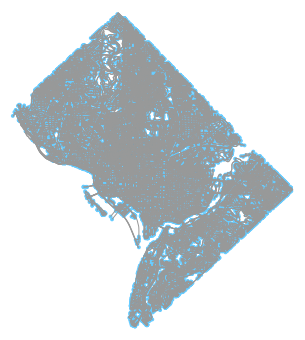

(<Figure size 375.668x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f51848c14f0>)

In [147]:
def get_edge_grade(edge):
    u, v = edge
    df = gdf_clean[(gdf_clean['u'] == u) & (gdf_clean['v'] == v)]
    if len(df)>0:
        max_g = list(df['max_grade_est'])[0]
        min_g = list(df['min_grade_est'])[0]
        return max(float(max_g),abs(float(min_g)))
    else:
        return 0
import matplotlib.cm as cm
import matplotlib.colors as colors
mg = [get_edge_grade(edge) for edge in G.edges()]
norm = colors.Normalize(vmin=min(mg)*0.8, vmax=max(mg))
cmap = cm.ScalarMappable(norm=mg, cmap=cm.inferno)
mg_color = [cmap.to_rgba(grade) for grade in mg]
ox.plot.plot_graph(G_proj, edge_color=mg_color)

TypeError: 'list' object is not callable

In [133]:
list(G.edges())[0]

(2039087104, 2039087110)